<a href="https://colab.research.google.com/github/sofiagpmg/Detecting-Cyberbully/blob/main/Trial_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-pretrained-bert
!pip install transformers

     |████████████████████████████████| 133kB 8.9MB/s 
     |████████████████████████████████| 133kB 29.1MB/s 
     |████████████████████████████████| 6.7MB 26.7MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
ERROR: botocore 1.19.8 has requirement urllib3<1.26,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 1.3MB 8.4MB/s 
     |████████████████████████████████| 2.9MB 39.7MB/s 
     |████████████████████████████████| 890kB 55.0MB/s 
     |████████████████████████████████| 1.1MB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c390e393a6e0714567c79cfac84ba0853165c49638271f2759502b8ac61c7d35
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import os
import re
import csv
import itertools

import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from collections import defaultdict, OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
import pytorch_pretrained_bert

In [ ]:
# Get GPU device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# tell Pytorch to use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Import BioBERT

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt

--2020-10-30 09:19:07--  https://docs.google.com/uc?export=download&confirm=SHBa&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD
Resolving docs.google.com (docs.google.com)... 173.194.69.101, 173.194.69.113, 173.194.69.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.69.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-b4-docs.googleusercontent.com/docs/securesc/a49h21l6skdv9f155bhs1f94lfg7nnls/ggj2d2kb4sf7lesqga30pgc3spqom2lt/1604049525000/13799006341648886493/09688102489001817463Z/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download [following]
--2020-10-30 09:19:07--  https://doc-08-b4-docs.googleusercontent.com/docs/securesc/a49h21l6skdv9f155bhs1f94lfg7nnls/ggj2d2kb4sf7lesqga30pgc3spqom2lt/1604049525000/13799006341648886493/09688102489001817463Z/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download
Resolving doc-08-b4-docs.googleusercontent.com (doc-08-b4-docs.googleusercontent.com)... 172.217.218.132, 2a00:1450:4013:c08::84
Connectin

In [ ]:
!tar -xzf biobert_weights
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.index  vocab.txt
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta


In [ ]:
!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

2020-10-30 09:19:22.685469: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

Converting TensorFlow checkpoint from /content/biobert_v1.1_pubmed/model.ckpt-1000000
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading 

In [ ]:
!ls biobert_v1.1_pubmed/
!mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt
config.json				model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt


In [ ]:
!ls 

biobert_v1.1_pubmed  biobert_weights  sample_data


# Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
MAX_LEN = 75
BATCH_SIZE = 32
tokenizer = BertTokenizer(vocab_file='biobert_v1.1_pubmed/vocab.txt', do_lower_case=False)

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/bio_ner/bionlp_tags.csv')
tag_values = data['tags'].values
vocab_len = len(tag_values)
print('Entity Types:',vocab_len)

Entity Types: 74


In [ ]:
df_tags = pd.DataFrame({'tags':tag_values})
df_tags.to_csv('bionlp_tags.csv',index=False)
df = pd.read_csv('bionlp_tags.csv')
print('Tag Preview:\n', df)

Tag Preview:
                       tags
0     I-Cellular_component
1   E-Gene_or_gene_product
2   I-Organism_subdivision
3     I-Organism_substance
4   B-Gene_or_gene_product
..                     ...
69                 I-Organ
70                S-Cancer
71            B-Amino_acid
72     S-Anatomical_system
73                     PAD

[74 rows x 1 columns]


In [ ]:
class SentenceFetch(object):
  
  def __init__(self, data):
    self.data = data
    self.sentences = []
    self.tags = []
    self.sent = []
    self.tag = []
    
    # make tsv file readable
    with open(self.data) as tsv_f:
      reader = csv.reader(tsv_f, delimiter='\t')
      for row in reader:
        if len(row) == 0:
          if len(self.sent) != len(self.tag):
            break
          self.sentences.append(self.sent)
          self.tags.append(self.tag)
          self.sent = []
          self.tag = []
        else:
          self.sent.append(row[0])
          self.tag.append(row[1])   

  def getSentences(self):
    return self.sentences
  
  def getTags(self):
    return self.tags

In [ ]:
corpora = '/content/gdrive/My Drive/Colab Notebooks/Data/bionlp_corpora'
sentences = []
tags = []
for subdir, dirs, files in os.walk(corpora):
    for file in files:
        if file == 'train.tsv':
            path = os.path.join(subdir, file)
            sent = SentenceFetch(path).getSentences()
            tag = SentenceFetch(path).getTags()
            sentences.extend(sent)
            tags.extend(tag)
            
sentences = sentences[0:20000]
tags = tags[0:20000]

In [ ]:
print('Sentence Preview:\n',sentences[0])

Sentence Preview:
 ['The', 'Cdc6', 'protein', 'is', 'ubiquitinated', 'in', 'vivo', 'for', 'proteolysis', 'in', 'Saccharomyces', 'cerevisiae', '.']


In [ ]:
def tok_with_labels(sent, text_labels):
  '''tokenize and keep labels intact'''
  tok_sent = []
  labels = []
  for word, label in zip(sent, text_labels):
    tok_word = tokenizer.tokenize(word)
    n_subwords = len(tok_word)

    tok_sent.extend(tok_word)
    labels.extend([label] * n_subwords)
  return tok_sent, labels

tok_texts_and_labels = [tok_with_labels(sent, labs) for sent, labs in zip(sentences, tags)]

In [ ]:
tok_texts = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels]
labels = [tok_label_pair[1] for tok_label_pair in tok_texts_and_labels]

In [ ]:
len(tok_texts)

20000

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
for char in tok_texts:
    print('WordPiece Tokenizer Preview:\n', char)
    break

WordPiece Tokenizer Preview:
 ['The', 'C', '##d', '##c', '##6', 'protein', 'is', 'u', '##bi', '##qui', '##tina', '##ted', 'in', 'v', '##ivo', 'for', 'pro', '##te', '##oly', '##sis', 'in', 'Sa', '##cc', '##har', '##omy', '##ces', 'c', '##ere', '##vis', '##iae', '.']


In [ ]:
tag_values = list(set(itertools.chain.from_iterable(tags)))
tag_values.append("PAD")

tag2idx = {t: i for i,t in enumerate(tag_values)}

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
# attention masks make explicit reference to which tokens are actual words vs padded words
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

# Model

In [ ]:
config = BertConfig.from_json_file('biobert_v1.1_pubmed/config.json')
tmp_d = torch.load('biobert_v1.1_pubmed/pytorch_model.bin', map_location=device)
state_dict = OrderedDict()

for i in list(tmp_d.keys())[:199]:
    x = i
    if i.find('bert') > -1:
        x = '.'.join(i.split('.')[1:])
    state_dict[x] = tmp_d[i]

In [ ]:
class BioBertNER(nn.Module):

  def __init__(self, vocab_len, config, state_dict):
    super().__init__()
    self.bert = BertModel(config)
    self.bert.load_state_dict(state_dict, strict=False)
    self.dropout = nn.Dropout(p=0.3)
    self.output = nn.Linear(self.bert.config.hidden_size, vocab_len)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    encoded_layer, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    encl = encoded_layer[-1]
    out = self.dropout(encl)
    out = self.output(out)
    return out, out.argmax(-1)

In [ ]:
model = BioBertNER(vocab_len,config,state_dict)
model.to(device)

BioBertNER(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
        

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)
epochs = 3
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    for step,batch in enumerate(data_loader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs,y_hat = model(b_input_ids,b_input_mask)
        
        _,preds = torch.max(outputs,dim=2)
        outputs = outputs.view(-1,outputs.shape[-1])
        b_labels_shaped = b_labels.view(-1)
        loss = loss_fn(outputs,b_labels_shaped)
        correct_predictions += torch.sum(preds == b_labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double()/len(data_loader) , np.mean(losses)

In [ ]:
def model_eval(model,data_loader,loss_fn,device):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
        
            outputs,y_hat = model(b_input_ids,b_input_mask)
        
            _,preds = torch.max(outputs,dim=2)
            outputs = outputs.view(-1,outputs.shape[-1])
            b_labels_shaped = b_labels.view(-1)
            loss = loss_fn(outputs,b_labels_shaped)
            correct_predictions += torch.sum(preds == b_labels)
            losses.append(loss.item())
        
    
    return correct_predictions.double()/len(data_loader) , np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
normalizer = BATCH_SIZE*MAX_LEN
loss_values = []

for epoch in range(epochs):
    
    total_loss = 0
    print(f'======== Epoch {epoch+1}/{epochs} ========')
    train_acc,train_loss = train_epoch(model,train_dataloader,loss_fn,optimizer,device,scheduler)
    train_acc = train_acc/normalizer
    print(f'Train Loss: {train_loss} Train Accuracy: {train_acc}')
    total_loss += train_loss.item()
    
    avg_train_loss = total_loss / len(train_dataloader)  
    loss_values.append(avg_train_loss)
    
    val_acc,val_loss = model_eval(model,valid_dataloader,loss_fn,device)
    val_acc = val_acc/normalizer
    print(f'Val Loss: {val_loss} Val Accuracy: {val_acc}')
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

======== Epoch 1/3 ========
Train Loss: 0.20507348560418795 Train Accuracy: 0.9524637359384253
Val Loss: 0.1048296152481011 Val Accuracy: 0.9566269841269842
======== Epoch 2/3 ========
Train Loss: 0.09420070371741088 Train Accuracy: 0.9647550325636471
Val Loss: 0.09104856618103527 Val Accuracy: 0.9574537037037036
======== Epoch 3/3 ========
Train Loss: 0.08270481394249847 Train Accuracy: 0.9657519242155124
Val Loss: 0.08849428369412346 Val Accuracy: 0.958617724867725
CPU times: user 6min, sys: 2min 59s, total: 8min 59s
Wall time: 9min


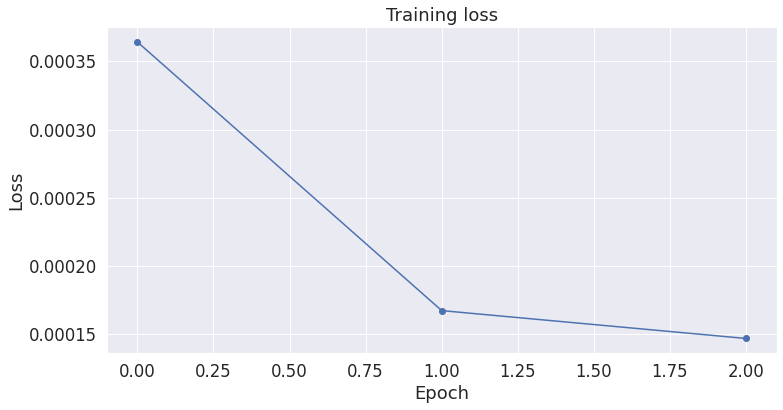

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# learning curve
plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Test

In [ ]:
text = """In addition to their essential catalytic role in protein biosynthesis, aminoacyl-tRNA synthetases participate in numerous other functions, including regulation of gene expression and amino acid biosynthesis via transamidation pathways. Herein, we describe a class of aminoacyl-tRNA synthetase-like (HisZ) proteins based on the catalytic core of the contemporary class II histidyl-tRNA synthetase whose members lack aminoacylation activity but are instead essential components of the first enzyme in histidine biosynthesis ATP phosphoribosyltransferase (HisG). Prediction of the function of HisZ in Lactococcus lactis was assisted by comparative genomics, a technique that revealed a link between the presence or the absence of HisZ and a systematic variation in the length of the HisG polypeptide. HisZ is required for histidine prototrophy, and three other lines of evidence support the direct involvement of HisZ in the transferase function. (i) Genetic experiments demonstrate that complementation of an in-frame deletion of HisG from Escherichia coli (which does not possess HisZ) requires both HisG and HisZ from L. lactis. (ii) Coelution of HisG and HisZ during affinity chromatography provides evidence of direct physical interaction. (iii) Both HisG and HisZ are required for catalysis of the ATP phosphoribosyltransferase reaction. This observation of a common protein domain linking amino acid biosynthesis and protein synthesis implies an early connection between the biosynthesis of amino acids and proteins."""

In [ ]:
nltk.download('punkt')
sent_text = nltk.sent_tokenize(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenized_text = []
for sentence in sent_text:
    tokenized_text.append(nltk.word_tokenize(sentence))

In [ ]:
def tokenize_and_preserve(sentence):
    tokenized_sentence = []
    
    for word in sentence:
        tokenized_word = tokenizer.tokenize(word)   
        tokenized_sentence.extend(tokenized_word)

    return tokenized_sentence

In [ ]:
tok_texts = [
    tokenize_and_preserve(sent) for sent in tokenized_text
]

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts]
input_attentions = [[1]*len(in_id) for in_id in input_ids]

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[1])
new_tokens, new_labels = [], []
for token in tokens:
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        
        new_tokens.append(token)

In [ ]:
actual_sentences = []
pred_labels = []
for x,y in zip(input_ids,input_attentions):
    x = torch.tensor(x).cuda()
    y = torch.tensor(y).cuda()
    x = x.view(-1,x.size()[-1])
    y = y.view(-1,y.size()[-1])
    with torch.no_grad():
        _,y_hat = model(x,y)
    label_indices = y_hat.to('cpu').numpy()
    
    tokens = tokenizer.convert_ids_to_tokens(x.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    actual_sentences.append(new_tokens)
    pred_labels.append(new_labels)

In [ ]:
for token, label in zip(actual_sentences, pred_labels):
    for t,l in zip(token,label):
        print("{}\t{}".format(t, l))

In [ ]:
model_save = 'BIONER_classifier.pt'
path = F"models/{model_save}" 
torch.save(model.state_dict(), path)

FileNotFoundError: ignored